In [1]:
!pip install keras
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install opencv-contrib-python==3.4.2.17
!pip install pandas
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install scikit-optimize
!pip install shortuuid
!pip install tensorflow-gpu
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-y8g19t8i
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-y8g19t8i
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-py3-none-any.whl size=84100 sha256=ceb7c0c54a8c6d2501c631ed0ebc6ad65a338a6e3884a2db0ecf323f558558a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_uzcjdi/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import copy
import csv
import glob
import pathlib
import os
import re
import shutil
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shortuuid
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from collections import Counter
from datetime import timedelta
from IPython.display import display
from PIL import Image
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)


def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C1"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data-c1/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data-c1/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data-c1/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data-c1/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data-c1/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data-c1/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data-c1/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"
TEST_PATCHES_DATA_DIR = "data/test/patches"

# Keras ImageDataGenerator expects that files are in a subdirectory
TEST_PATCHES_GEN_DATA_DIR = os.path.join(TEST_PATCHES_DATA_DIR, "test")

## GPU configuration
If you have a GPU, enable experimental memory growth.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data
Generate random, stratified 80/20 split for training and validation sets

In [186]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [187]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [188]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [217]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data-c1/train/patches exists. Skipping.
data-c1/val/patches exists. Skipping.
data/test/patches exists. Skipping.
Generating ALL train data patches...
Generating ALL training patch data annotations...
Done.


In [4]:
class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_generator,
                 train_prediction_generator,
                 val_generator=None,
                 val_prediction_generator=None,
                 test_generator=None,
                 train_patch_ann_df=None,
                 val_patch_ann_df=None,
                 train_whole_image_ann_df=None,
                 val_whole_image_ann_df=None):
        self.class_weights = class_weights
        self.train_generator = train_generator
        self.train_prediction_generator = train_prediction_generator
        self.val_generator = val_generator
        self.val_prediction_generator = val_prediction_generator
        self.test_generator = test_generator
        self.train_patch_ann_df = train_patch_ann_df
        self.val_patch_ann_df = val_patch_ann_df
        self.train_whole_image_ann_df = train_whole_image_ann_df
        self.val_whole_image_ann_df = val_whole_image_ann_df

In [5]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True
    )
    train_datagen = ImageDataGenerator(**data_gen_args)
    val_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
    
    print("Defining validation data generator...")
    val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    
    
    val_prediction_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=False,
            target_size=(224,224)
    )
        
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            val_generator, 
                            val_prediction_generator,
                            test_generator,
                            train_ann_df,
                            val_ann_df,
                            train_whole_image_ann_df, 
                            val_whole_image_ann_df)


In [6]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_ALL_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        y_col="annotation",
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        target_size=(224,224)
    )
    
    train_prediction_generator = train_datagen.flow_from_dataframe(
        dataframe=ann_df,
        directory=TRAIN_ALL_PATCHES_DATA_DIR,
        x_col="file_name",
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
   
        
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )  
    
    
    return SoybeanDataGroup(class_weights, 
                            train_generator,
                            train_prediction_generator,
                            None, 
                            None,
                            test_generator,
                            ann_df,
                            None,
                            train_whole_image_ann_df)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [7]:
def get_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [13]:
BATCH_SIZE = 32

def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    

def train(run_id, model, group, num_epochs):     
    model.summary()

    print('Fitting model...')
    
    print('group.train_patch_ann_df.shape[0]=', group.train_patch_ann_df.shape[0])
    print('int(group.train_patch_ann_df.shape[0] / BATCH_SIZE)', int(group.train_patch_ann_df.shape[0] / BATCH_SIZE))

    monitor = 'val_loss' if group.val_generator is not None else 'loss'
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=10, restore_best_weights=True)
    
    
    validation_steps = None if group.val_generator is None else int(group.val_patch_ann_df.shape[0] / BATCH_SIZE)
    
    history = model.fit(group.train_generator, 
                        steps_per_epoch=int(group.train_patch_ann_df.shape[0] / BATCH_SIZE), 
                        epochs=num_epochs,  
                        class_weight=group.class_weights,
                        validation_data=group.val_generator,
                        validation_steps=validation_steps,
                        verbose=1,
                        callbacks=[es])

    
    return model, history


def get_all_labels(ann_df):
    return ann_df['annotation'].to_numpy(dtype=int)


def get_all_whole_image_filenames(whole_image_ann_df):
    return whole_image_ann_df['file_name'].to_numpy()
    

def get_all_whole_image_labels(ann_df):
    return get_all_labels(ann_df)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, group):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Loss vs Epochs plot
    plt.plot(history.history['loss'], label='Training loss')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_loss'], label = 'Validation loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    # Accuracy vs Epochs plot
    plt.plot(history.history['accuracy'], label='Training accuracy')
    
    if group.val_generator is not None:
        plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    

    # Training confusion matrix
    train_patch_labels = get_all_labels(group.train_patch_ann_df)
    train_patch_predictions = predict(model, group.train_prediction_generator)
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    # Generate prediction label results file
    write_patch_predictions(run_id, 'train', output_dir, group.train_patch_ann_df, train_patch_predictions)
    
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    train_whole_image_filenames = get_all_whole_image_filenames(group.train_whole_image_ann_df)
    train_whole_image_labels = get_all_whole_image_labels(group.train_whole_image_ann_df)
    train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
    print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
    write_whole_image_predictions(run_id, 'train', output_dir, 
                                  train_whole_image_filenames, 
                                  train_whole_image_labels, 
                                  train_whole_image_predictions)
    
    # Validation confusion matrix
    if group.val_generator is not None:
        val_patch_labels = get_all_labels(group.val_patch_ann_df)
        val_patch_predictions = predict(model, group.val_prediction_generator)
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
      
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        val_whole_image_filenames = get_all_whole_image_filenames(group.val_whole_image_ann_df)
        val_whole_image_labels = get_all_whole_image_labels(group.val_whole_image_ann_df)
        val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
        print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
        # Generate prediction label results file
        write_patch_predictions(run_id, 'val', output_dir, group.val_patch_ann_df, val_patch_predictions)
        
        write_whole_image_predictions(run_id, 'val', output_dir, 
                                  val_whole_image_filenames, 
                                  val_whole_image_labels, 
                                  val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    model_trained.save_weights(os.path.join(output_dir, "{}_weights.h5".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group)
    
    # Classify test data
    return predict(model_trained, group.test_generator)


def predict(model, data_generator):
    y_hat_logits = model.predict(data_generator)
    y_hat = tf.map_fn(lambda x: tf.argmax(x), y_hat_logits, dtype=tf.int64).numpy()
    print('prediction => ', np.bincount(y_hat))
    return y_hat



def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    print("Distribution")
    print('-' * 8)
    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    labels = [0, 1, 2, 3, 4]
    matrix = confusion_matrix(y, y_hat)
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, patch_ann_df, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for idx, row in patch_ann_df.iterrows():
        file_name, label = row
        df = df.append({'file_name': file_name, 
                        'annotation': label, 
                        'prediction': patch_predictions[i]}, ignore_index=True)
        i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    print('filenames:', len(filenames))
    print('labels:', len(labels))
    print('predictions:', len(predictions))
    
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [9]:
def run_trial(name, model, group=None, class_weights=None, num_epochs=80):
    run_id = shortuuid.uuid()
    
    if group is None:
        group = train_val_split_group(class_weights)
    
    # output directory
    output_dir = os.path.join("output_tf", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, group, num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/BaEgtsNXnPT6ELNo2wqpbk
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_63  (None, 512)               0         
_________________________________________________________________
dense_189 (Dense)            (None, 1024)        

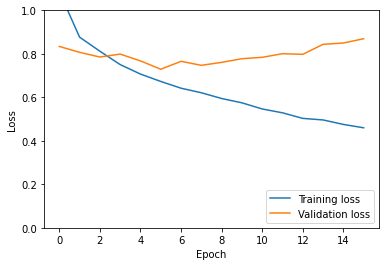

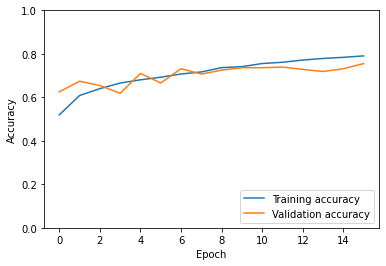

prediction =>  [6962 5373 3842 2440 1883]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,6412,2406,888,44,0
1,439,2680,550,30,1
2,106,250,1962,274,8
3,5,37,438,1994,151
4,0,0,4,98,1723


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,287,89,14,0,0
1,12,122,14,0,0
2,1,2,96,5,0
3,0,0,13,91,1
4,0,0,0,2,71


filenames: 820
labels: 820
predictions: 820
prediction =>  [1620 1420  986  607  492]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1471,652,308,19,0
1,107,672,132,14,0
2,39,82,410,116,3
3,3,14,136,434,63
4,0,0,0,24,426


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,68,25,5,0,0
1,3,31,3,0,0
2,0,2,20,4,0
3,0,0,3,22,1
4,0,0,0,1,17


filenames: 205
labels: 205
predictions: 205
prediction =>  [1666  975  822  502 1035]
predictions file: output_tf/BaEgtsNXnPT6ELNo2wqpbk/BaEgtsNXnPT6ELNo2wqpbk_predict_c2_h1_test.csv
Distribution
--------
0: 70
1: 42
2: 30
3: 11
4: 47
Finished generating predictions to output_tf/BaEgtsNXnPT6ELNo2wqpbk/BaEgtsNXnPT6ELNo2wqpbk_predict_c2_h1_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [196]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model)

#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/G3oUBRawvBBwY4tbiCobY5
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_64  (None, 512)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 2048)        

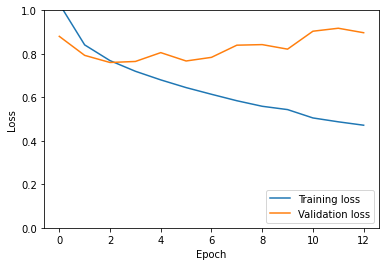

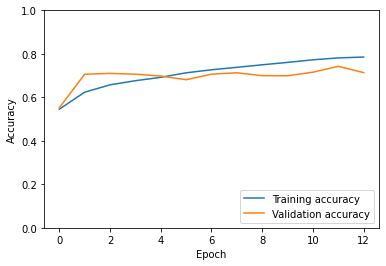

prediction =>  [9502 2799 4036 2307 1856]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7991,877,858,24,0
1,1190,1743,703,63,1
2,280,160,1858,293,9
3,41,19,608,1803,154
4,0,0,9,124,1692


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,362,18,10,0,0
1,49,74,24,1,0
2,5,2,91,6,0
3,0,0,17,86,2
4,0,0,0,2,71


filenames: 820
labels: 820
predictions: 820
prediction =>  [2256  769 1039  586  475]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1924,220,296,10,0
1,261,488,165,11,0
2,60,54,411,123,2
3,11,7,167,403,62
4,0,0,0,39,411


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,87,7,4,0,0
1,12,21,4,0,0
2,1,1,20,4,0
3,0,0,3,22,1
4,0,0,0,1,17


filenames: 205
labels: 205
predictions: 205
prediction =>  [1946  666  802  661  925]
predictions file: output_tf/G3oUBRawvBBwY4tbiCobY5/G3oUBRawvBBwY4tbiCobY5_predict_c2_h2_test.csv
Distribution
--------
0: 80
1: 25
2: 33
3: 19
4: 43
Finished generating predictions to output_tf/G3oUBRawvBBwY4tbiCobY5/G3oUBRawvBBwY4tbiCobY5_predict_c2_h2_test.csv


array([0, 0, 0, ..., 0, 0, 0])

In [197]:
model = get_model(2048, 256, 0.5)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/WjMmdmH6sGtJfJpNfzQBig
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_65  (None, 512)               0         
_________________________________________________________________
dense_195 (Dense)            (None, 512)         

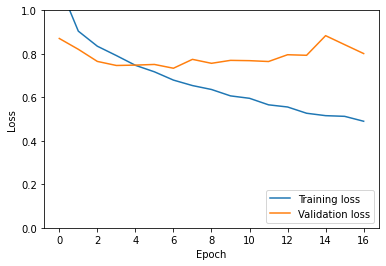

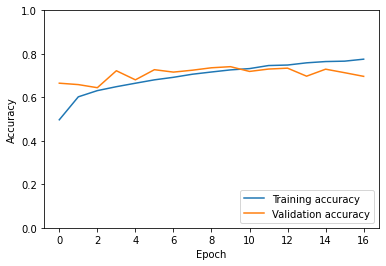

prediction =>  [8829 4559 2919 2338 1855]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,7716,1635,381,18,0
1,846,2520,301,31,2
2,252,344,1767,226,11
3,15,60,466,1946,138
4,0,0,4,117,1704


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,337,46,7,0,0
1,29,115,4,0,0
2,3,6,91,4,0
3,0,1,16,84,4
4,0,0,0,2,71


filenames: 820
labels: 820
predictions: 820
prediction =>  [2079 1247  747  588  464]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1827,461,151,11,0
1,186,637,93,9,0
2,57,122,361,109,1
3,9,27,141,427,46
4,0,0,1,32,417


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,82,14,2,0,0
1,5,29,3,0,0
2,0,5,17,4,0
3,0,1,3,21,1
4,0,0,0,2,16


filenames: 205
labels: 205
predictions: 205
prediction =>  [2180  772  548  500 1000]
predictions file: output_tf/WjMmdmH6sGtJfJpNfzQBig/WjMmdmH6sGtJfJpNfzQBig_predict_c2_h3_test.csv
Distribution
--------
0: 101
1: 25
2: 17
3: 10
4: 47
Finished generating predictions to output_tf/WjMmdmH6sGtJfJpNfzQBig/WjMmdmH6sGtJfJpNfzQBig_predict_c2_h3_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [198]:
model = get_model(512, 64, 0.5)
run_trial("h3", model)

#### H4: 4096-512-5

* DNN Structure: 4096-512-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/iHvt84pE6vZ7XV8wMC2Z27
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_66  (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 4096)        

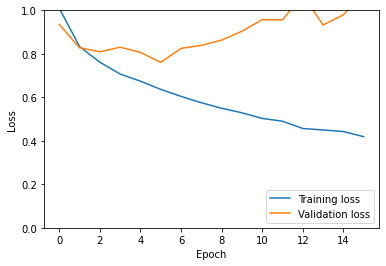

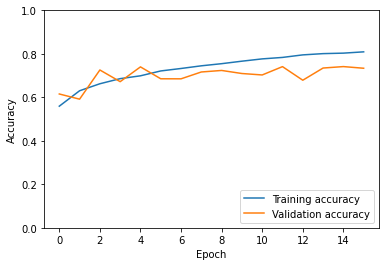

prediction =>  [7475 4498 4370 2203 1954]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,6913,1968,830,38,1
1,401,2444,828,22,5
2,149,81,2158,196,16
3,12,5,549,1883,176
4,0,0,5,64,1756


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,327,54,9,0,0
1,7,110,31,0,0
2,1,0,102,1,0
3,0,0,18,86,1
4,0,0,0,0,73


filenames: 820
labels: 820
predictions: 820
prediction =>  [1801 1126 1154  530  514]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1624,527,274,21,4
1,125,567,220,12,1
2,43,25,495,82,5
3,9,7,165,396,73
4,0,0,0,19,431


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,79,15,4,0,0
1,5,25,7,0,0
2,1,0,24,1,0
3,0,0,5,20,1
4,0,0,0,0,18


filenames: 205
labels: 205
predictions: 205
prediction =>  [1849  554 1080  532  985]
predictions file: output_tf/iHvt84pE6vZ7XV8wMC2Z27/iHvt84pE6vZ7XV8wMC2Z27_predict_c2_h4_test.csv
Distribution
--------
0: 88
1: 9
2: 47
3: 11
4: 45
Finished generating predictions to output_tf/iHvt84pE6vZ7XV8wMC2Z27/iHvt84pE6vZ7XV8wMC2Z27_predict_c2_h4_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [200]:
model = get_model(4096, 512, 0.5)
run_trial("h4", model)

#### H5: 4096-1024-5

* DNN Structure: 4096-1024-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/Q8XVBe27cCNk4QQ5MY2vbK
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_67  (None, 512)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 4096)        

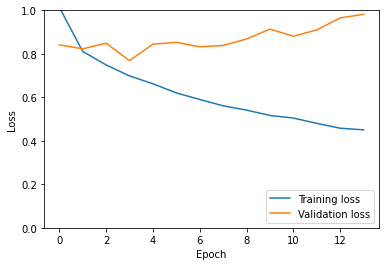

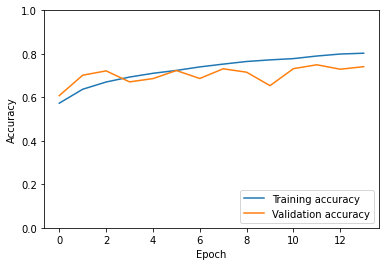

prediction =>  [7215 5513 3539 2506 1727]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,6639,2382,715,14,0
1,395,2791,435,79,0
2,171,298,1888,238,5
3,10,42,487,2013,73
4,0,0,14,162,1649


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,302,72,16,0,0
1,12,125,11,0,0
2,2,7,92,3,0
3,0,0,14,90,1
4,0,0,0,4,69


filenames: 820
labels: 820
predictions: 820
prediction =>  [1718 1400  922  639  446]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1549,622,270,7,2
1,120,671,120,14,0
2,46,88,386,129,1
3,3,19,144,437,47
4,0,0,2,52,396


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,72,18,8,0,0
1,4,30,3,0,0
2,0,3,17,6,0
3,0,0,4,21,1
4,0,0,0,1,17


filenames: 205
labels: 205
predictions: 205
prediction =>  [1783  940  717  799  761]
predictions file: output_tf/Q8XVBe27cCNk4QQ5MY2vbK/Q8XVBe27cCNk4QQ5MY2vbK_predict_c2_h5_test.csv
Distribution
--------
0: 84
1: 35
2: 18
3: 27
4: 36
Finished generating predictions to output_tf/Q8XVBe27cCNk4QQ5MY2vbK/Q8XVBe27cCNk4QQ5MY2vbK_predict_c2_h5_test.csv


array([2, 2, 0, ..., 0, 0, 0])

In [202]:
model = get_model(4096, 1024, 0.5)
run_trial("h5", model)

#### H6: 4096-2048-5

* DNN Structure: 4096-2048-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/g65DrfC5S7GUbrfALjc5qV
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_68  (None, 512)               0         
_________________________________________________________________
dense_204 (Dense)            (None, 4096)        

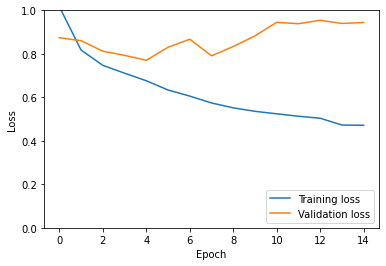

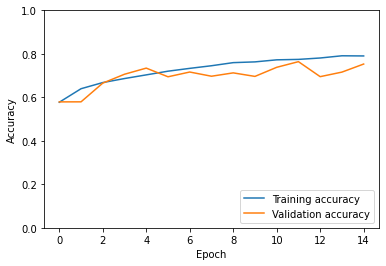

prediction =>  [9789 3669 2420 2476 2146]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8477,886,333,54,0
1,987,2395,254,58,6
2,292,317,1574,389,28
3,32,70,257,1941,325
4,1,1,2,34,1787


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,374,14,2,0,0
1,34,112,2,0,0
2,4,9,79,11,1
3,0,0,6,90,9
4,0,0,0,1,72


filenames: 820
labels: 820
predictions: 820
prediction =>  [2355  969  626  606  569]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,2025,262,128,32,3
1,249,576,78,21,1
2,71,109,318,145,7
3,10,22,102,401,115
4,0,0,0,7,443


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,91,4,3,0,0
1,10,25,1,1,0
2,1,6,14,5,0
3,0,0,3,20,3
4,0,0,0,0,18


filenames: 205
labels: 205
predictions: 205
prediction =>  [2255  771  368  447 1159]
predictions file: output_tf/g65DrfC5S7GUbrfALjc5qV/g65DrfC5S7GUbrfALjc5qV_predict_c2_h6_test.csv
Distribution
--------
0: 101
1: 31
2: 4
3: 13
4: 51
Finished generating predictions to output_tf/g65DrfC5S7GUbrfALjc5qV/g65DrfC5S7GUbrfALjc5qV_predict_c2_h6_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [203]:
model = get_model(4096, 2048, 0.5)
run_trial("h6", model)

#### H7: 4096-4096-5

* DNN Structure: 4096-4096-5
* Dropout: 0.5
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/aWzQdVB8QNeGXxSj6Sw4DW
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_69  (None, 512)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 4096)        

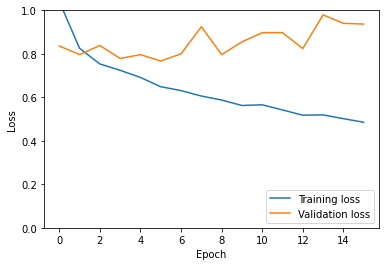

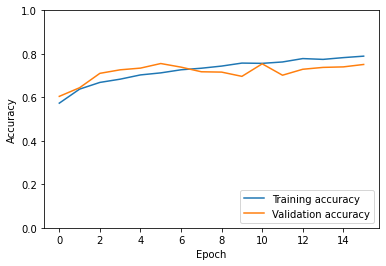

prediction =>  [10362  2725  2925  2602  1886]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8809,512,385,44,0
1,1200,2082,356,62,0
2,320,112,1871,287,10
3,33,19,308,2132,133
4,0,0,5,77,1743


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,380,10,0,0,0
1,47,93,8,0,0
2,7,0,90,7,0
3,0,0,8,95,2
4,0,0,0,1,72


filenames: 820
labels: 820
predictions: 820
prediction =>  [2519  744  725  675  462]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,2113,171,147,19,0
1,304,498,107,15,1
2,90,60,363,135,2
3,12,15,108,477,38
4,0,0,0,29,421


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,92,4,2,0,0
1,14,20,3,0,0
2,2,2,18,4,0
3,0,0,3,23,0
4,0,0,0,0,18


filenames: 205
labels: 205
predictions: 205
prediction =>  [2339  471  606  582 1002]
predictions file: output_tf/aWzQdVB8QNeGXxSj6Sw4DW/aWzQdVB8QNeGXxSj6Sw4DW_predict_c2_h7_test.csv
Distribution
--------
0: 104
1: 13
2: 18
3: 17
4: 48
Finished generating predictions to output_tf/aWzQdVB8QNeGXxSj6Sw4DW/aWzQdVB8QNeGXxSj6Sw4DW_predict_c2_h7_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [205]:
model = get_model(4096, 4096, 0.5)
run_trial("h7", model)

#### H8: Best from above, dropout 0.25

* DNN Structure: 4096-4096-5
* Dropout: 0.25
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/4dUYDeaqN454m66sqk7r57
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_70  (None, 512)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 4096)        

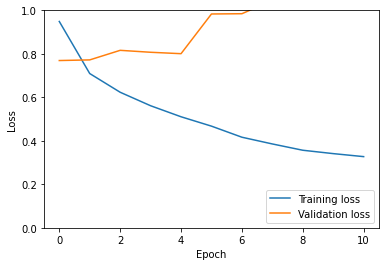

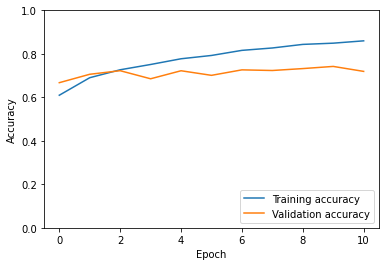

prediction =>  [7940 3511 4596 2529 1924]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,6978,1432,1275,65,0
1,748,1948,902,100,2
2,194,120,1879,387,20
3,20,11,534,1853,207
4,0,0,6,124,1695


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,319,44,27,0,0
1,25,87,35,1,0
2,3,1,90,9,1
3,0,0,16,82,7
4,0,0,0,3,70


filenames: 820
labels: 820
predictions: 820
prediction =>  [1848  950 1194  642  491]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1619,376,422,33,0
1,171,527,213,14,0
2,53,39,424,132,2
3,5,8,135,431,71
4,0,0,0,32,418


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,74,11,13,0,0
1,5,25,7,0,0
2,1,0,20,5,0
3,0,0,3,21,2
4,0,0,0,1,17


filenames: 205
labels: 205
predictions: 205
prediction =>  [1862  450 1039  684  965]
predictions file: output_tf/4dUYDeaqN454m66sqk7r57/4dUYDeaqN454m66sqk7r57_predict_c2_h8_test.csv
Distribution
--------
0: 80
1: 11
2: 45
3: 23
4: 41
Finished generating predictions to output_tf/4dUYDeaqN454m66sqk7r57/4dUYDeaqN454m66sqk7r57_predict_c2_h8_test.csv


array([2, 0, 0, ..., 0, 0, 0])

In [206]:
model = get_model(4096, 4096, 0.25)
run_trial("h8", model)

#### H9: Best from above, dropout 0.1

* DNN Structure: 4096-4096-5
* Dropout: 0.1
* Class weights: balanced
* Batch normalization: no


Output generated to: output_tf/JTYmzZ63hHW675PSPxdcad
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_71  (None, 512)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 4096)        

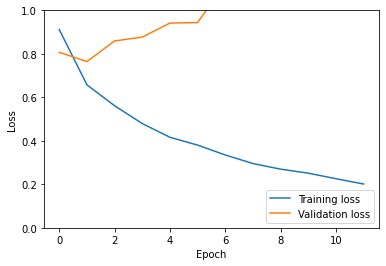

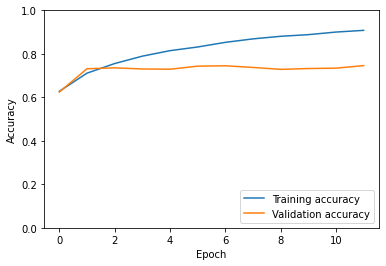

prediction =>  [9490 3317 3140 2768 1785]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,8367,827,496,60,0
1,849,2293,490,67,1
2,247,173,1826,348,6
3,27,24,323,2153,98
4,0,0,5,140,1680


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,372,14,4,0,0
1,24,108,16,0,0
2,5,2,86,11,0
3,0,0,10,94,1
4,0,0,0,3,70


filenames: 820
labels: 820
predictions: 820
prediction =>  [2289  873  783  724  456]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1979,260,187,24,0
1,244,531,128,22,0
2,59,71,355,164,1
3,7,11,112,474,46
4,0,0,1,40,409


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,90,6,2,0,0
1,9,23,4,1,0
2,1,3,16,6,0
3,0,0,3,22,1
4,0,0,0,1,17


filenames: 205
labels: 205
predictions: 205
prediction =>  [2270  517  595  695  923]
predictions file: output_tf/JTYmzZ63hHW675PSPxdcad/JTYmzZ63hHW675PSPxdcad_predict_c2_h9_test.csv
Distribution
--------
0: 105
1: 12
2: 19
3: 23
4: 41
Finished generating predictions to output_tf/JTYmzZ63hHW675PSPxdcad/JTYmzZ63hHW675PSPxdcad_predict_c2_h9_test.csv


array([0, 0, 0, ..., 0, 0, 0])

In [207]:
model = get_model(4096, 4096, 0.1)
run_trial("h9", model)

#### H10: Best from above, skewed class weights

* DNN Structure: 4096-4096-5
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


In [ ]:
model = get_model(4096, 4096, 0.5)
run_trial("h10", model, class_weights=[1., 1., 5., 5., 1.])

Reading annotations...
Using class weights: [1.0, 1.0, 5.0, 5.0, 1.0]
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Found 20500 validated image filenames.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5125 validated image filenames.
Found 5000 images belonging to 1 classes.
Output generated to: output_tf/5d4pdWzMtRfF4iovUyhSvo
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dropout_4 (Dr

#### Summary: Best hyperparameters

In [ ]:
optimal_n1 = 4096
optimal_n2 = 4096
optimal_d = 0.5


## Train with all C2 data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d)
run_trial("a1", model, group=all_train_data_group(), num_epochs=25)
